In [86]:
import matplotlib.image as _mpimg
import matplotlib.pyplot as _plt
import networkx as _nx
import pydot as _pydot
from rdkit.Chem import AllChem as _AllChem
from rdkit.Chem import Draw as _Draw
import os as _os
import warnings as _warnings
with _warnings.catch_warnings():
    _warnings.filterwarnings("ignore")
    from rdkit import Chem as _Chem
    from rdkit.Chem import rdFMCS as _rdFMCS
    from rdkit.Chem import rdmolops as _rdmolops
    from rdkit.Chem import rdchem as _rdchem
    from rdkit import RDLogger as _RDLogger

    # Disable RDKit warnings.
    _RDLogger.DisableLog('rdApp.*')
# Set the DPI to make the network look nice.
_plt.rcParams["figure.dpi"]= 250

work_dir = "tmp/lomap_workdir"
tgt = "cats_5"


In [87]:
import glob
import BioSimSpace as BSS
# Make directory for output images.
_os.makedirs(work_dir + "/images", exist_ok=True)

path_to_ligands = f"/home/jscheen/projects/FEPSPACE/fep_ref_ligands/{tgt}"
ligand_files = glob.glob(f"{path_to_ligands}/*.mol2")

molecules = []
names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    molecules.append(BSS.IO.readMolecules(filepath)[0])

    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    names.append(filepath.split("/")[-1].replace(".mol2",""))

In [88]:
edges = [(0,1),(0,2),(1,2)]
scores = [0.5, 0.5, 0.5]
nodes = [0, 1, 2]

In [89]:
        
# 1) Loop over each molecule and load into RDKit.
rdmols = []
for x, name in zip(range(0, len(molecules)), names):
    file = f"{work_dir}/inputs/{x:03d}_{name}.mol2"
    rdmols.append(_Chem.rdmolfiles.MolFromMol2File(file, sanitize=False, removeHs=False))


# 2) Find the MCS of the molecules to use as a template.
rdmols = [_Chem.RemoveHs(mol) for mol in rdmols]

template = _Chem.MolFromSmarts(_rdFMCS.FindMCS(rdmols, timeout=10, 
                                    atomCompare=_rdFMCS.AtomCompare.CompareAny,
                                    bondCompare=_rdFMCS.BondCompare.CompareAny,
                                    matchValences=False,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    matchChiralTag=False
                                              ).smartsString)
_AllChem.Compute2DCoords(template)


template
    

OSError: Bad input file tmp/lomap_workdir/inputs/000_CatS_184.mol2

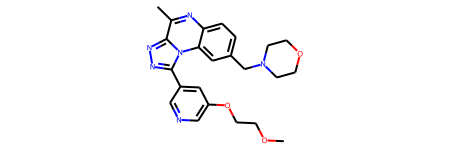

In [85]:
# 3) Load all ligands, make 2D depiction aligned to the template and save to file.

for x, mol in enumerate(rdmols):
    mol.UpdatePropertyCache(strict=False)
    _AllChem.Compute2DCoords(mol)
    _AllChem.GenerateDepictionMatching2DStructure(mol, template)

    mol = _Chem.RemoveHs(mol)
    _rdmolops.RemoveStereochemistry(mol)
    _Draw.MolToFile(mol, f"{work_dir}/images/{x:03d}.png")

mol